In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Урок 6. Сегментация

### Домашнее задание:

1. Попробуйте обучить нейронную сеть U-Net на любом другом датасете. 
2. Опишите в комментарии к уроку - какой результата вы добились от нейросети? Что помогло вам улучшить ее точность?
3. *Попробуйте свои силы в задаче Carvana на Kaggle - https://www.kaggle.com/c/carvana-image-masking-challenge/overview
4. *Сделайте свою реализацию U-Net на TensorFlow

### Подключение библиотек

In [2]:
import os
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, UpSampling2D, Concatenate, Input, Softmax

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

### Данные

Ссылка: Kaggle. Cityscapes Image Pairs

Cityscapes data (dataset home page) contains labeled videos taken from vehicles driven in Germany. This version is a processed subsample created as part of the Pix2Pix paper. The dataset has still images from the original videos, and the semantic segmentation labels are shown in images alongside the original image. This is one of the best datasets around for semantic segmentation tasks.

This dataset has 2975 training images files and 500 validation image files. Each image file is 256x512 pixels, and each file is a composite with the original photo on the left half of the image, alongside the labeled image (output of semantic segmentation) on the right half.

### Функции:

In [6]:
PATH_TRAIN = '/kaggle/input/cityscapes-image-pairs/cityscapes_data/train'
PATH_VAL = '/kaggle/input/cityscapes-image-pairs/cityscapes_data/val'

num_of_training_samples = len(os.listdir(PATH_TRAIN)) 
num_of_valid_samples = len(os.listdir(PATH_VAL))

In [10]:
def load_image(name, path):
  img = Image.open(os.path.join(path, name))
  img = np.array(img)
  
  image = img[:,:256]
  mask = img[:,256:]
  
  return image, mask

def bin_image(mask):
  bins = np.array([20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240])
  new_mask = np.digitize(mask, bins)
  return new_mask

def get_segmentation_arr(image, classes, width=WIDTH, height=HEIGHT):
  seg_labels = np.zeros((height, width, classes))
  img = image[:, : , 0]

  for c in range(classes):
    seg_labels[:, :, c] = (img == c ).astype(int)
  return seg_labels

def give_color_to_seg_img(seg, n_classes=N_CLASSES):
  seg_img = np.zeros((seg.shape[0],seg.shape[1],3)).astype('float')
  colors = sns.color_palette("hls", n_classes)
  
  for c in range(n_classes):
    segc = (seg == c)
    seg_img[:,:,0] += (segc * (colors[c][0]))
    seg_img[:,:,1] += (segc * (colors[c][1]))
    seg_img[:,:,2] += (segc * (colors[c][2]))

  return (seg_img)

def data_generator(path, batch_size=BATCH_SIZE, classes=N_CLASSES):
  files = os.listdir(path)
  while True:
    for i in range(0, len(files), batch_size):
      batch_files = files[i : i+batch_size]
      imgs=[]
      segs=[]
      for file in batch_files:
        image, mask = load_image(file, path)
        mask_binned = bin_image(mask)
        labels = get_segmentation_arr(mask_binned, classes)

        imgs.append(image)
        segs.append(labels)

      yield np.array(imgs), np.array(segs)

### Подготовка данных

In [11]:
EPOCHS=10
BATCH_SIZE=10
HEIGHT=256
WIDTH=256
N_CLASSES=13

train_gen = data_generator(PATH_TRAIN, batch_size=BATCH_SIZE)
val_gen = data_generator(PATH_VAL, batch_size=BATCH_SIZE)

In [12]:
imgs, segs = next(train_gen)
imgs.shape, segs.shape

((10, 256, 256, 3), (10, 256, 256, 13))

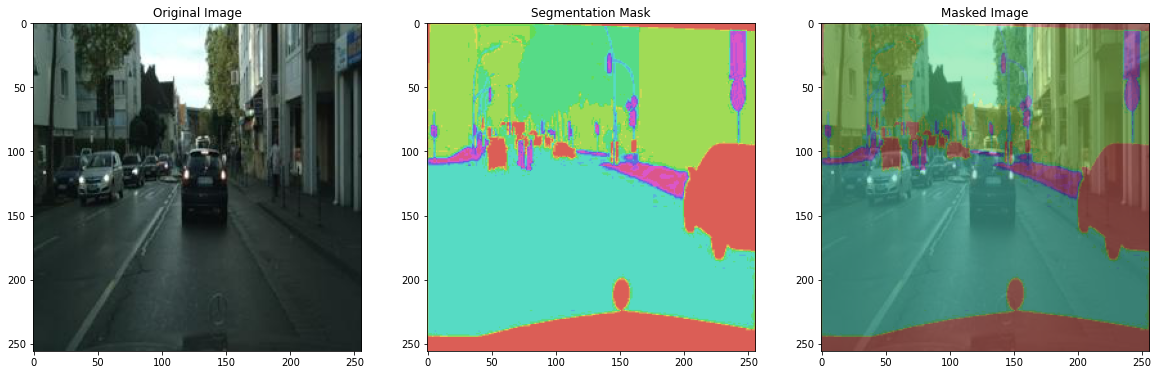

In [13]:
image = imgs[5]
mask = give_color_to_seg_img(np.argmax(segs[0], axis=-1))
masked_image = cv2.addWeighted(image/255, 0.5, mask, 0.5, 0)

fig, axs = plt.subplots(1, 3, figsize=(20,20))
axs[0].imshow(image)
axs[0].set_title('Original Image')

axs[1].imshow(mask)
axs[1].set_title('Segmentation Mask')

axs[2].imshow(masked_image)
axs[2].set_title('Masked Image')
plt.show()

### Построение модели

In [14]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = UpSampling2D((2, 2))(x)
    concat = Concatenate()([us, skip])
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = Input((HEIGHT, WIDTH, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = Conv2D(13, (1, 1), padding="same", activation="sigmoid")(u4)
    model = Model(inputs, outputs)
    return model

In [15]:
model = UNet()
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["acc"])
model.summary()

2023-01-13 09:04:35.388422: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-13 09:04:35.389689: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-13 09:04:35.547676: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-13 09:04:35.548781: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-13 09:04:35.549808: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 16) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

### Обучение

In [16]:
TRAIN_STEPS = num_of_training_samples // BATCH_SIZE + 1
VAL_STEPS = num_of_valid_samples // BATCH_SIZE + 1

history = model.fit_generator(
  train_gen,
  validation_data=val_gen,
  steps_per_epoch=TRAIN_STEPS,
  validation_steps=VAL_STEPS,
  epochs=EPOCHS
)

2023-01-13 09:05:12.091541: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2023-01-13 09:05:14.462306: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


298/298 [==============================] - 111s 333ms/step - loss: 1.6826 - acc: 0.5077 - val_loss: 1.1766 - val_acc: 0.6760
Epoch 2/10
298/298 [==============================] - 72s 242ms/step - loss: 1.1101 - acc: 0.6894 - val_loss: 1.0910 - val_acc: 0.6869
Epoch 3/10
298/298 [==============================] - 71s 240ms/step - loss: 0.9810 - acc: 0.7253 - val_loss: 0.9365 - val_acc: 0.7368
Epoch 4/10
298/298 [==============================] - 71s 238ms/step - loss: 0.8885 - acc: 0.7523 - val_loss: 0.8799 - val_acc: 0.7509
Epoch 5/10
298/298 [==============================] - 70s 235ms/step - loss: 0.8319 - acc: 0.7676 - val_loss: 0.8298 - val_acc: 0.7653
Epoch 6/10
298/298 [==============================] - 70s 235ms/step - loss: 0.7871 - acc: 0.7790 - val_loss: 0.8264 - val_acc: 0.7644
Epoch 7/10
298/298 [==============================] - 70s 234ms/step - loss: 0.7614 - acc: 0.7854 - val_loss: 0.7959 - val_acc: 0.7727
Epoch 8/10
298/298 [==============================] - 72s 243ms/s

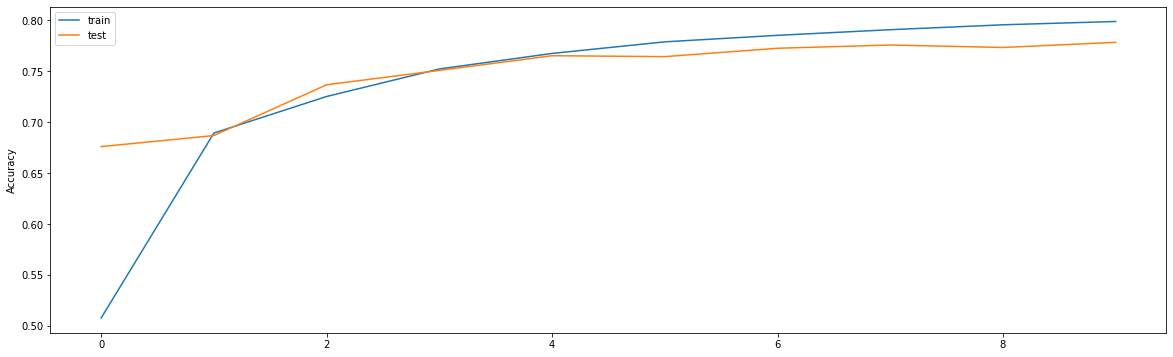

In [19]:
plt.figure(figsize=(20, 6))

plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Визуализация предсказаний

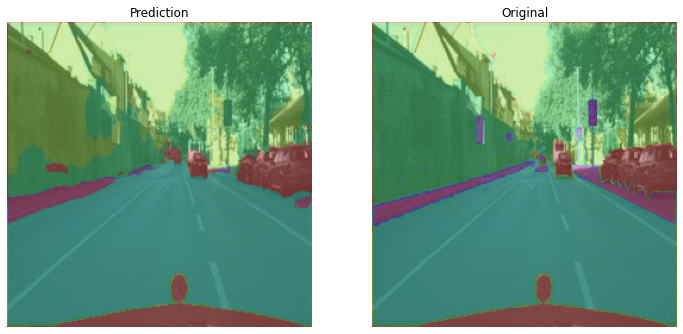

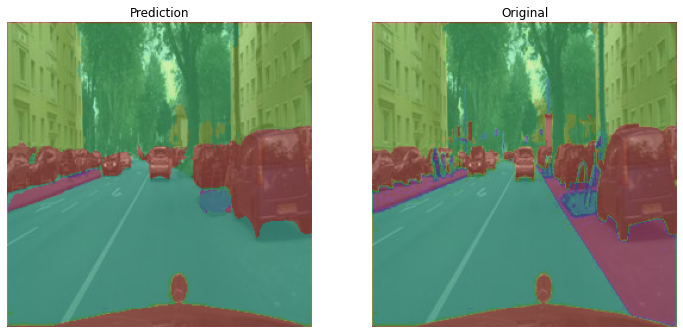

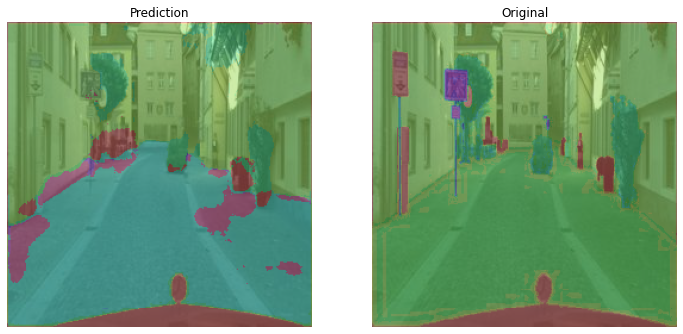

In [20]:
max_show = 3
imgs, segs = next(val_gen)
pred = model.predict(imgs)

for i in range(max_show):
  _p = give_color_to_seg_img(np.argmax(pred[i], axis=-1))
  _s = give_color_to_seg_img(np.argmax(segs[i], axis=-1))

  predimg = cv2.addWeighted(imgs[i]/255, 0.5, _p, 0.5, 0)
  trueimg = cv2.addWeighted(imgs[i]/255, 0.5, _s, 0.5, 0)
  
  plt.figure(figsize=(12,6))
  plt.subplot(121)
  plt.title("Prediction")
  plt.imshow(predimg)
  plt.axis("off")

  plt.subplot(122)
  plt.title("Original")
  plt.imshow(trueimg)
  plt.axis("off")
  plt.show()